# Data Training and Prediction

Train models and predict the test data

In [1]:
# Import libraries
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

In [38]:
# Read data and separate into features and target
df = pd.read_csv('processed_train_data.csv')
X = df.drop('Bankrupt?', axis=1)
y = df['Bankrupt?']

In [32]:
# Select features with highest correlation to target
correlations = df.corr()['Bankrupt?'].abs().sort_values(ascending=False)
correlations = correlations.drop('Bankrupt?')
correlations = correlations.where(correlations.abs() >= 0.25).dropna()
X = X[correlations.index]

# Model Selection
To build a stacking model with 3 different non-parametric models, we can test the performance of the following models:
- kNeighborsClassifier
- DecisionTreeClassifier
- RandomForestClassifier
- BaggingClassifier
- GradientBoostingClassifier
- GaussianProcessClassifier
- SVC

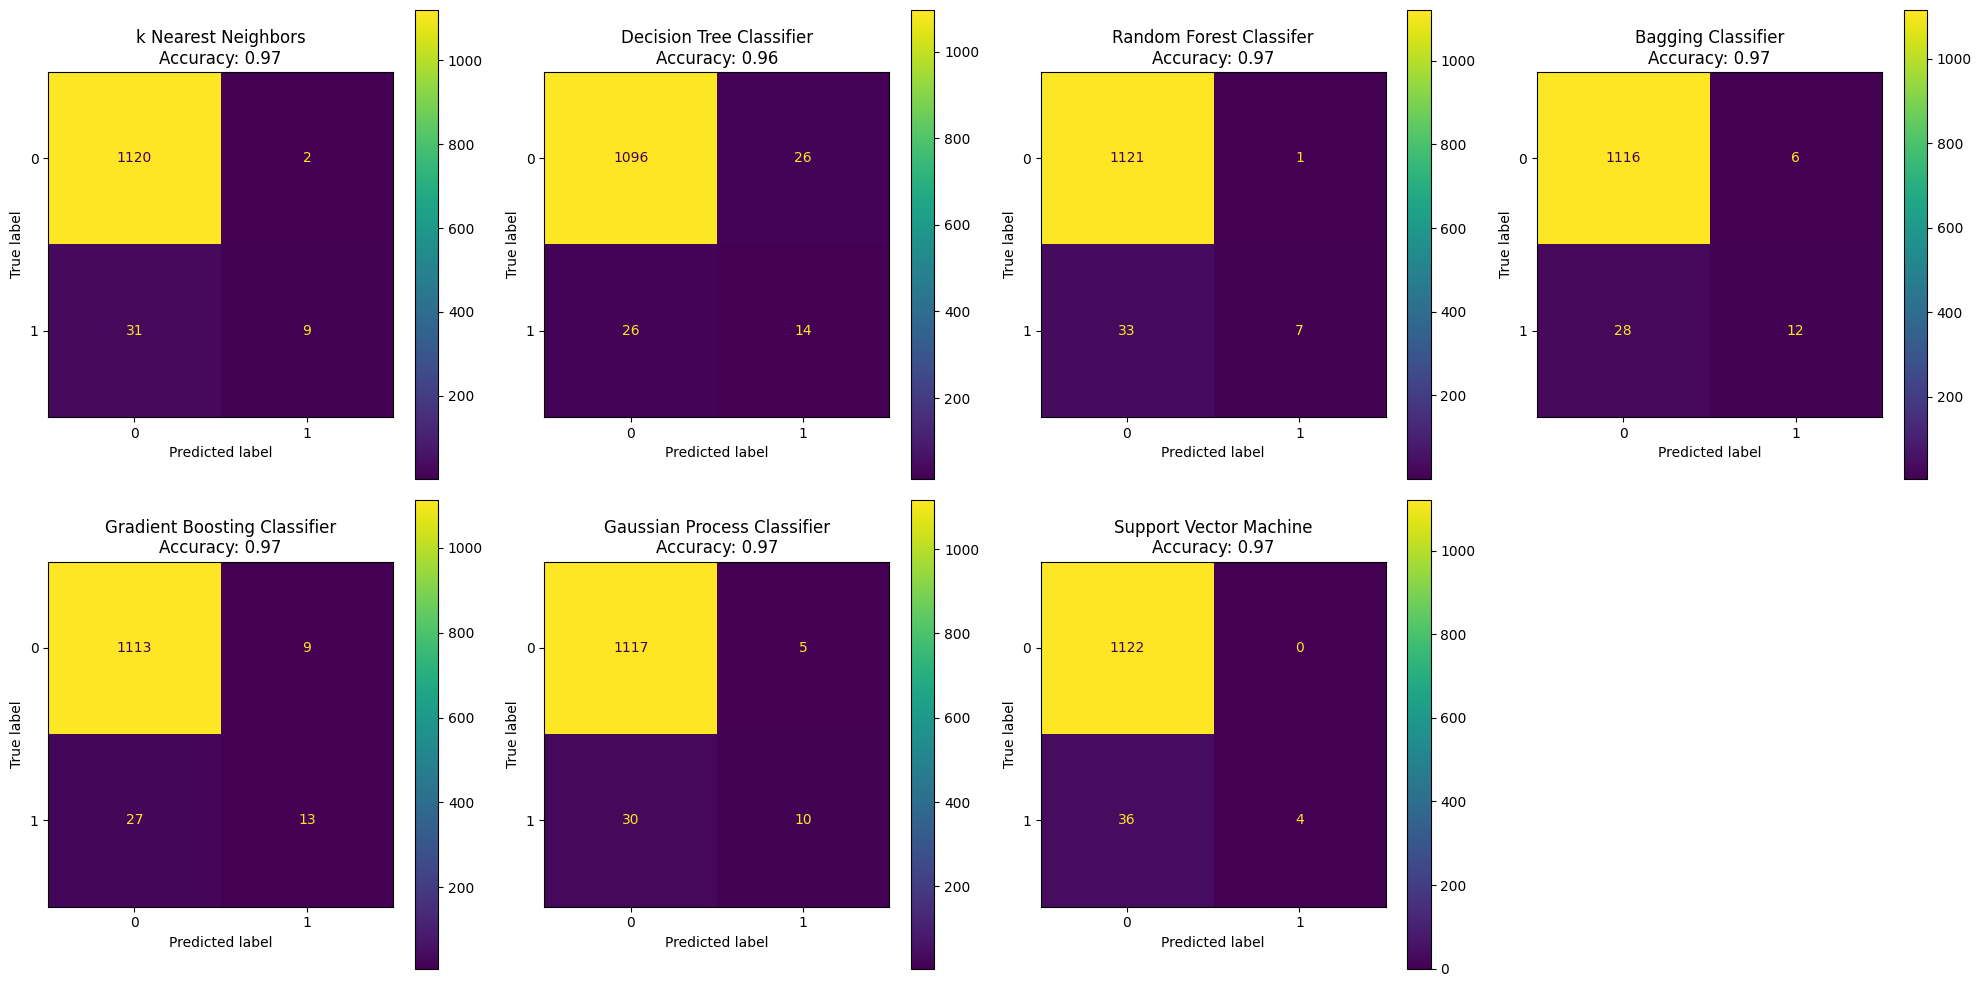

In [40]:
# Define all models
knn = KNeighborsClassifier()
dtc = DecisionTreeClassifier(random_state=42)
rfc = RandomForestClassifier(random_state=42)
bc = BaggingClassifier(random_state=42)
gbc = GradientBoostingClassifier(random_state=42)
gpc = GaussianProcessClassifier(random_state=42)
svc = SVC(random_state=42)

models = [knn, dtc, rfc, bc, gbc, gpc, svc]
model_names = ["k Nearest Neighbors", "Decision Tree Classifier", "Random Forest Classifer", "Bagging Classifier", 
               "Gradient Boosting Classifier", "Gaussian Process Classifier", "Support Vector Machine"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

fig, axes = plt.subplots(2, 4, figsize=(20, 10)) 
axes = axes.flatten()

for idx, (model, name) in enumerate(zip(models, model_names)):
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    
    disp.plot(ax=axes[idx])
    axes[idx].set_title(f'{name}\nAccuracy: {score:.2f}')

for i in range(len(models), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

The best performing models are:
- kNN
- Gaussian Process Classifier
- Support Vector Machine

# Create Stacking Model
Using the models above, we can create a stacking model and test its performance using cross-validation.

In [37]:
base_models = [
    ("knn", KNeighborsClassifier()),
    ("gpc", GaussianProcessClassifier(random_state=42)),
    ("svm", SVC(random_state=42))
]

meta_learner = LogisticRegression(random_state=42)

stacking_model = StackingClassifier(estimators=base_models, final_estimator=meta_learner, cv=2)

cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)
cv_results = []

for train_idx, test_idx in cv.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    stacking_model.fit(X_train, y_train)
    y_pred = stacking_model.predict(X_test)
    acc = stacking_model.score(X_test, y_test)
    
    # Store results
    cv_results.append({
        "Accuracy": acc,
        "Confusion Matrix": confusion_matrix(y_test, y_pred)
    })

# Report results
for i, result in enumerate(cv_results):
    print(f"Fold {i+1}: Accuracy = {result['Accuracy']}")
    print("Confusion Matrix:")
    print(result["Confusion Matrix"])

Fold 1: Accuracy = 0.9669421487603306
Confusion Matrix:
[[2802    3]
 [  93    6]]
Fold 2: Accuracy = 0.9679641749913882
Confusion Matrix:
[[2802    2]
 [  91    8]]
